# SegCPGP demo

In [1]:
from cpgp.segcpgp import SegCPGP
import numpy as np
import matplotlib.pyplot as plt
import os
import gpflow
import seaborn as sns
import os
import sys
parent_directory = os.path.abspath('..')
sys.path.append(parent_directory)

2025-02-10 20:12:34.655026: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-10 20:12:34.719582: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-10 20:12:34.863342: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-10 20:12:34.863404: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-10 20:12:34.872978: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

### General use of SegCPGP

Consider the following mean change dataset, with a change in mean at $t=50$:

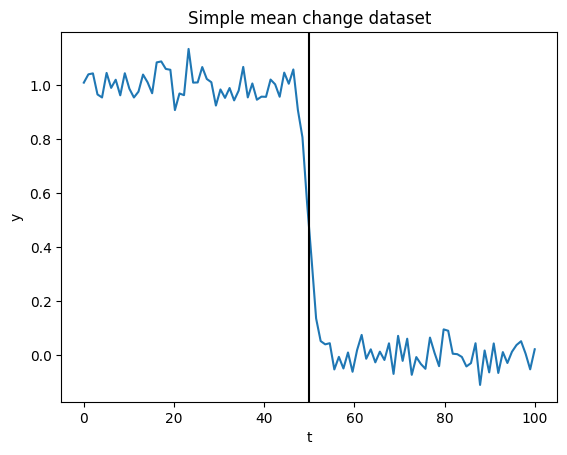

In [2]:
# Generate simple mean change dataset
X = np.linspace(0, 100, 100).reshape(-1, 1)
y = (1 / (1 + np.exp(X - 50))).reshape(-1, 1) + \
    np.random.normal(0, 0.05, X.shape[0]).reshape(-1, 1)
plt.plot(X, y)
plt.axvline(50, linestyle="-", color="black", label="true CP location")

plt.title("Simple mean change dataset")
plt.xlabel("t")
plt.ylabel("y")
plt.show()

### Fitting SegCPGP
We have implemented a number of kernels used in our experiments directly:

| String       | Kernel description                                                 |
|--------------|--------------------------------------------------------------------|
| "rbf"        | Squared exponential/RBF kernel.                                    |
| "constant"   | Constant kernel.                                                   |
| "matern"     | Matern52 kernel.                                                   |
| "spectral-q" | Spectral mixture kernel with q components. q should be an integer. |
| "noise"      | White kernel.                                                      |
| "linear"     | Linear kernel.                                                     |
| "per"        | Periodic(RBF) kernel.                                              |

SegCPGP is fit as demonstrated. The _p_-value for SegCPGP's likelihood ratio test can be controlled through the keyword argument `pval`.

In [3]:
# Fit CPGP with the constant kernel
segcpgp = SegCPGP(pval=0.05)
segcpgp.fit(X, y, "constant")

0.0 100.0
p 4.479445458165588e-101 df 3 location [49.83261581] steepness [1.05709354]
0.0 43.43434343434344
p 0.5692493304194373 df 3 location [7.57563993] steepness [0.00158359]
54.54545454545455 100.0
p 1.0 df 3 location [86.38005546] steepness [0.10975663]


([array([49.83261581])], [array([1.05709354])])

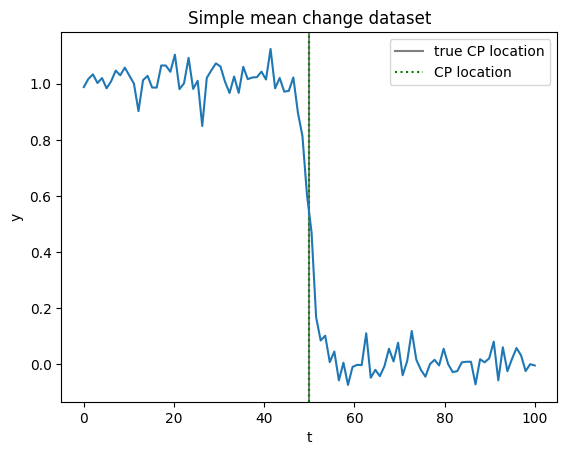

In [4]:

plt.axvline(50, linestyle="-", color="black",
            alpha=0.5, label="true CP location")
for loc in segcpgp.LOCS:
    plt.axvline(loc, linestyle=":", color="green", label="CP location")
X = np.linspace(0, 100, 100).reshape(-1, 1)
y = (1 / (1 + np.exp(X - 50))).reshape(-1, 1) + \
    np.random.normal(0, 0.05, X.shape[0]).reshape(-1, 1)
plt.plot(X, y)
plt.title("Simple mean change dataset")
plt.xlabel("t")
plt.ylabel("y")
plt.legend()
plt.show()

In [5]:
# Fit CPGP with a custom kernel
segcpgp = SegCPGP()
segcpgp.fit(X, y, custom_kernel=gpflow.kernels.RBF()+gpflow.kernels.Linear())

0.0 100.0


KeyboardInterrupt: 

### Spectral mixture kernel
The spectral mixture kernel can be used as a flexible changepoint detection kernel. Consider the following trend change dataset, with a change at $t=50$:

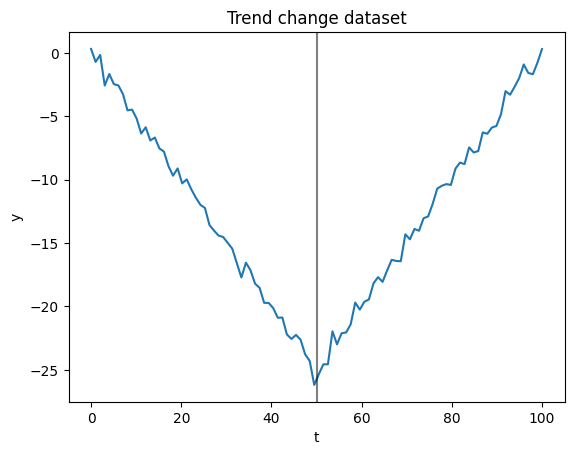

In [6]:
X = np.linspace(0, 100, 100).reshape(-1, 1)
y = []
y[:50] = -0.5 * X[:50]
y[50:] = 0.5 * X[50:] - 100*0.5
y += np.random.normal(0, 0.5, size=len(X)).reshape(-1, 1)
plt.plot(X, y)

plt.axvline(50, linestyle="-", color="black",
            alpha=0.5, label="true CP location")

plt.title("Trend change dataset")
plt.xlabel("t")
plt.ylabel("y")

plt.show()

If SegCPGP is fit on this dataset with a constant kernel, the changepoint at index 50 is not found:

In [7]:
segcpgp_constant = SegCPGP(0.05)
segcpgp_constant.fit(X, y, "constant")

0.0 100.0
LML tf.Tensor(-344.7143169289508, shape=(), dtype=float64)
6.378451785218737e-08 3
p 6.378451785218737e-08 df 3 bic tf.Tensor(11.256993749370821, shape=(), dtype=float64) location [85.63440649] steepness [0.20581643]
0.0 79.7979797979798
LML tf.Tensor(-271.0805612591671, shape=(), dtype=float64)
3.2309132630232375e-24 3
p 3.2309132630232375e-24 df 3 bic tf.Tensor(49.66055265604424, shape=(), dtype=float64) location [18.34834893] steepness [0.15480458]
0.0 12.121212121212121
LML tf.Tensor(-30.028312146225346, shape=(), dtype=float64)
5.258154189731712e-07 3
p 5.258154189731712e-07 df 3 bic tf.Tensor(12.147726903576643, shape=(), dtype=float64) location [7.02680284] steepness [0.37814397]
23.232323232323235 79.7979797979798
LML tf.Tensor(-167.94905756023718, shape=(), dtype=float64)
2.8563743364802634e-06 3
p 2.8563743364802634e-06 df 3 bic tf.Tensor(8.183894585887709, shape=(), dtype=float64) location [78.36913273] steepness [0.19354193]
23.232323232323235 72.72727272727273
LM

([array([85.63440649]),
  array([18.34834893]),
  array([7.02680284]),
  array([78.36913273])],
 [array([0.20581643]),
  array([0.15480458]),
  array([0.37814397]),
  array([0.19354193])])

The spectral mixture kernel, on the other hand, usually does find the changepoint:

In [8]:
segcpgp_spectral = SegCPGP(0.05, attempts=10)
segcpgp_spectral.fit(X, y, "spectral-1")

0.0 100.0
LML tf.Tensor(-121.82599470287701, shape=(), dtype=float64)
4.246814866300603e-11 5
p 4.246814866300603e-11 df 5 bic tf.Tensor(17.170987260217867, shape=(), dtype=float64) location [48.58544523] steepness [18.06436589]
0.0 42.42424242424243
LML tf.Tensor(-36.90934527238099, shape=(), dtype=float64)
0.9351185144568063 5
p 0.9351185144568063 df 5 bic tf.Tensor(-8.753908684357972, shape=(), dtype=float64) location [-61.79117317] steepness [0.12068567]
53.535353535353536 100.0
LML tf.Tensor(-45.81582103170369, shape=(), dtype=float64)
0.5303629609240488 5
p 0.5303629609240488 df 5 bic tf.Tensor(-7.558629996696208, shape=(), dtype=float64) location [53.30792976] steepness [13.14789722]


([array([48.58544523])], [array([18.06436589])])

[array([48.58544523])]
[48.58544523]


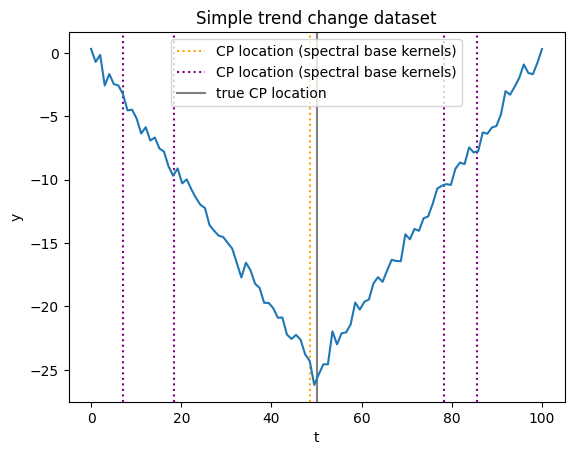

In [9]:
print(segcpgp_spectral.LOCS)
for loc in segcpgp_spectral.LOCS:
    print(loc)
    plt.axvline(loc, linestyle=":", color="orange",
                label="CP location (spectral base kernels)")

for loc in segcpgp_constant.LOCS[:-1]:
    plt.axvline(loc, linestyle=":", color="purple")
plt.axvline(segcpgp_constant.LOCS[-1], linestyle=":",
            color="purple", label="CP location (spectral base kernels)")

plt.axvline(50, linestyle="-", color="black",
            alpha=0.5, label="true CP location")

plt.plot(X, y)
plt.title("Simple trend change dataset")
plt.xlabel("t")
plt.ylabel("y")
plt.legend()
plt.show()